## Notebook for Running Experiments on CovType Data Set

In [1]:
#%load_ext nb_black
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


from test_harness.datasets.dataset import Dataset
from test_harness.experiments.base_experiment import Experiment
from test_harness.experiments.experiment_container import ExperimentContainer
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.response_uncertainty_experiment import (
    UncertaintyKSExperiment,
)
from test_harness.experiments.margin_uncertainty_experiment import (
    UncertaintyX2Experiment,
)
from test_harness.experiments.margin_threshold_experiment import (
    MarginThresholdExperiment,
)
from test_harness.utils.utils import (
    plot_experiment_error,
    plot_multiple_experiments,
    aggregate_experiment_metrics,
    plot_response_distributions_bysplit,
    plot_margin_distributions_bysplit,
    format_experimental_scores,
    calculate_split_window_distances,
)



## Load Data

In [3]:
with open("../data/covtype_induced_drift_forward_norm.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

In [4]:
drift_df

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type
0,0.449482,0.952778,0.227273,0.136006,0.227390,0.098356,0.740157,0.850394,0.653543,0.164645,0.0,0.0,1.0,0.0,1.0
1,0.516192,0.483333,0.212121,0.130279,0.258398,0.644935,0.893701,0.968504,0.582677,0.371532,1.0,0.0,0.0,0.0,1.0
2,0.672927,0.127778,0.424242,0.416607,0.242894,0.114093,0.850394,0.661417,0.279528,0.234351,0.0,1.0,0.0,0.0,0.0
3,0.706606,0.341667,0.181818,0.473157,0.260982,0.425741,0.944882,0.909449,0.472441,0.421581,0.0,0.0,1.0,0.0,1.0
4,0.570596,0.066667,0.121212,0.380100,0.279070,0.169594,0.850394,0.874016,0.562992,0.327199,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495136,0.065523,0.948819,0.736220,0.376985,0.763780,0.531736,0.266150,0.777778,0.136364,0.107373,0.0,1.0,0.0,0.0,1.0
495137,0.121428,0.988189,0.791339,0.439652,0.732283,0.587435,0.248062,0.677778,0.242424,0.085898,0.0,1.0,0.0,0.0,1.0
495138,0.062178,0.874016,0.594488,0.706758,0.818898,0.646373,0.298450,0.011111,0.136364,0.202577,0.0,0.0,0.0,1.0,1.0
495139,0.370277,0.866142,0.433071,0.509344,0.937008,0.516192,0.227390,0.244444,0.181818,0.021475,0.0,0.0,0.0,1.0,1.0


In [15]:
# with open("../data/covtype_nodrift_norm.pkl", "rb") as f:
#     drift_df = pickle.load(f)

## Experiments

### Prepare Test Harness

In [77]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

In [78]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

CT_dataset = Dataset(
    full_df=drift_df, column_mapping=column_mapping, window_size=17500 * 2
)

In [86]:
max_comp_num = drift_df.shape[1]

#### EDA on dataset

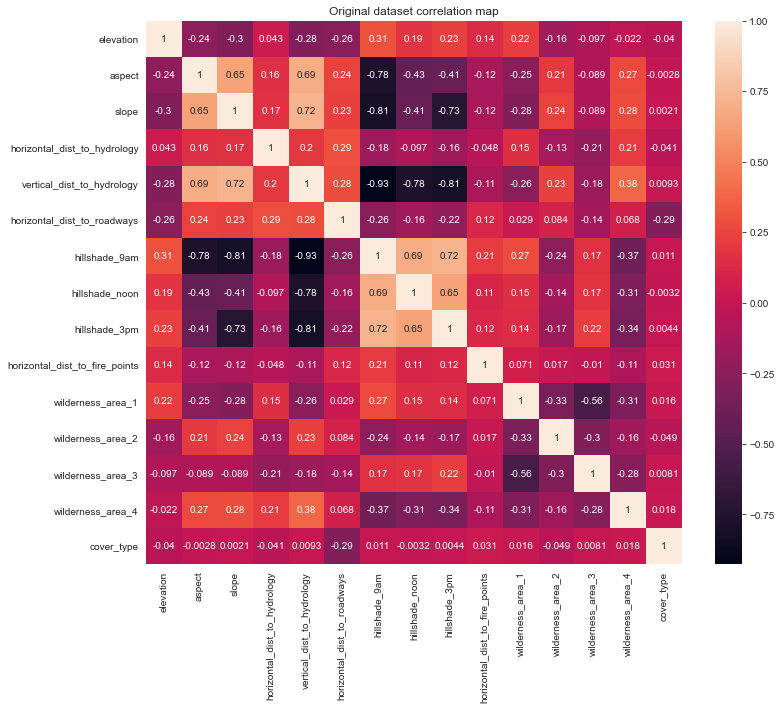

In [73]:
plt.figure(figsize=(12,10))
sns.heatmap(CT_dataset.full_df.corr(), annot=True)

plt.title('Original dataset correlation map')
plt.show()

## Run Experiments

### PCA dataset experiments

#### Create PCA reduced datasets

In [120]:
experiments = ExperimentContainer()

In [121]:
model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

In [122]:
column_mapping_pca = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

In [123]:
drift_df_scaled = pd.DataFrame(StandardScaler().fit_transform(drift_df.drop(column_mapping_pca['target'], axis=1)), columns=drift_df.columns[:-1])
drift_df_scaled[column_mapping_pca['target']] = drift_df[column_mapping_pca['target']]

In [124]:
for comp_num in range(2, max_comp_num):
    experiments.add_dataset(comp_num, Dataset(full_df=drift_df_scaled, column_mapping=column_mapping, window_size=17500 * 2, pca=True, pca_dim=comp_num))

Adding 2 dim. PCA dataset
Adding 3 dim. PCA dataset
Adding 4 dim. PCA dataset
Adding 5 dim. PCA dataset
Adding 6 dim. PCA dataset
Adding 7 dim. PCA dataset
Adding 8 dim. PCA dataset
Adding 9 dim. PCA dataset
Adding 10 dim. PCA dataset
Adding 11 dim. PCA dataset
Adding 12 dim. PCA dataset
Adding 13 dim. PCA dataset
Adding 14 dim. PCA dataset


In [126]:
for pca_dim, _dataset in experiments.dataset_container.items():

    print(f'PCA dim: {pca_dim}')

    print(f'BaselineExperiment')
    baseline = BaselineExperiment(model=model, dataset=_dataset, param_grid=param_grid, pca=True)
    baseline.run()
    experiments.add_model_iteration(baseline, 'BaselineExperiment')

    print(f'ToplineExperiment')
    topline = ToplineExperiment(model=model, dataset=_dataset, k=10, param_grid=param_grid, pca=True)
    topline.run()
    experiments.add_model_iteration(topline, 'ToplineExperiment')

    print(f'UncertaintyKSExperiment')
    uncertainty_ks = UncertaintyKSExperiment(model=model, dataset=_dataset, param_grid=param_grid, k=10, significance_thresh=0.001, pca=True)
    uncertainty_ks.run()
    experiments.add_model_iteration(uncertainty_ks, 'UncertaintyKSExperiment')

    print(f'UncertaintyX2Experiment')
    uncertainty_x2 = UncertaintyX2Experiment(model=model, dataset=_dataset, param_grid=param_grid, k=10, significance_thresh=0.001, margin_width=0.1, pca=True)
    uncertainty_x2.run()
    experiments.add_model_iteration(uncertainty_x2, 'UncertaintyX2Experiment')

    print(f'MarginThresholdExperiment_v1')
    margin_threshold_1 = MarginThresholdExperiment(model=model, dataset=_dataset, param_grid=param_grid, k=10, margin_width=0.1, sensitivity=1, pca=True)
    margin_threshold_1.run()
    experiments.add_model_iteration(margin_threshold_1, 'MarginThresholdExperiment_v1')

    print(f'MarginThresholdExperiment_v2\n')
    margin_threshold_2 = MarginThresholdExperiment(model=model, dataset=_dataset, param_grid=param_grid, k=10, margin_width=0.1, sensitivity=2, pca=True)
    margin_threshold_2.run()
    experiments.add_model_iteration(margin_threshold_2, 'MarginThresholdExperiment_v2')

    experiments.add_model(pca_dim)

PCA dim: 2
BaselineExperiment
ToplineExperiment
UncertaintyKSExperiment
UncertaintyX2Experiment
MarginThresholdExperiment_v1
MarginThresholdExperiment_v2

PCA dim: 3
BaselineExperiment
ToplineExperiment


KeyboardInterrupt: 

In [127]:
experiments.model_container

{2: {'BaselineExperiment': <test_harness.experiments.baseline_experiment.BaselineExperiment at 0x2630a20fd00>,
  'ToplineExperiment': <test_harness.experiments.topline_experiment.ToplineExperiment at 0x2630a29f2b0>,
  'UncertaintyKSExperiment': <test_harness.experiments.response_uncertainty_experiment.UncertaintyKSExperiment at 0x2630a29fc70>,
  'UncertaintyX2Experiment': <test_harness.experiments.margin_uncertainty_experiment.UncertaintyX2Experiment at 0x2630a27a850>,
  'MarginThresholdExperiment_v1': <test_harness.experiments.margin_threshold_experiment.MarginThresholdExperiment at 0x2630a27adc0>,
  'MarginThresholdExperiment_v2': <test_harness.experiments.margin_threshold_experiment.MarginThresholdExperiment at 0x2630a20fc40>}}

#### Original dataset experiment

In [ ]:
model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

In [18]:
# baseline experiment
baseline = BaselineExperiment(model=model, dataset=CT_dataset, param_grid=param_grid)
baseline.run()

In [19]:
# topline experiment
topline = ToplineExperiment(
    model=model, dataset=CT_dataset, k=10, param_grid=param_grid
)
topline.run()

In [20]:
# method 2 experiment
uncertainty_ks = UncertaintyKSExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
)
uncertainty_ks.run()

In [21]:
# method 3 experiment
uncertainty_x2 = UncertaintyX2Experiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    significance_thresh=0.001,
    margin_width=0.1,
)
uncertainty_x2.run()

In [22]:
# method 4 experiment (sensitivity = 1)
margin_threshold_1 = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.1,
    sensitivity=1,
)
margin_threshold_1.run()

In [23]:
# method 4 experiment (sensitivity = 2)
margin_threshold_2 = MarginThresholdExperiment(
    model=model,
    dataset=CT_dataset,
    param_grid=param_grid,
    k=10,
    margin_width=0.1,
    sensitivity=2,
)
margin_threshold_2.run()

## Plot Experimental Results

In [129]:
experiments.model_container[2]

{'BaselineExperiment': <test_harness.experiments.baseline_experiment.BaselineExperiment at 0x2630a20fd00>,
 'ToplineExperiment': <test_harness.experiments.topline_experiment.ToplineExperiment at 0x2630a29f2b0>,
 'UncertaintyKSExperiment': <test_harness.experiments.response_uncertainty_experiment.UncertaintyKSExperiment at 0x2630a29fc70>,
 'UncertaintyX2Experiment': <test_harness.experiments.margin_uncertainty_experiment.UncertaintyX2Experiment at 0x2630a27a850>,
 'MarginThresholdExperiment_v1': <test_harness.experiments.margin_threshold_experiment.MarginThresholdExperiment at 0x2630a27adc0>,
 'MarginThresholdExperiment_v2': <test_harness.experiments.margin_threshold_experiment.MarginThresholdExperiment at 0x2630a20fc40>}

In [132]:
exps = []

In [133]:
for k in experiments.model_container[2].keys():
    exps.append(experiments.model_container[2][k])

In [134]:
exps

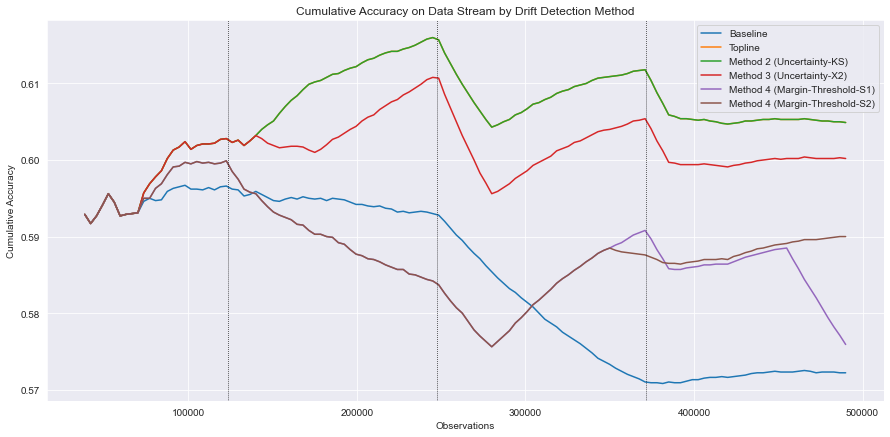

,drifts_signaled,actual_drift_occurences,false_positives,false_negatives,percent_total_labels,cumulative_accuracy,total_train_time
experiment,,,,,,,
Baseline,0,0,0,0,0.0707,0.5722,0.08
Topline,13,4,9,0,0.9896,0.6049,1.01
Method 2 (Uncertainty-KS),13,4,9,0,0.9896,0.6049,1.02
Method 3 (Uncertainty-X2),10,9,3,2,0.7776,0.6002,0.95
Method 4 (Margin-Threshold-S1),5,10,0,5,0.4241,0.5759,0.49
Method 4 (Margin-Threshold-S2),5,10,0,5,0.4241,0.5900,0.44


In [135]:
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

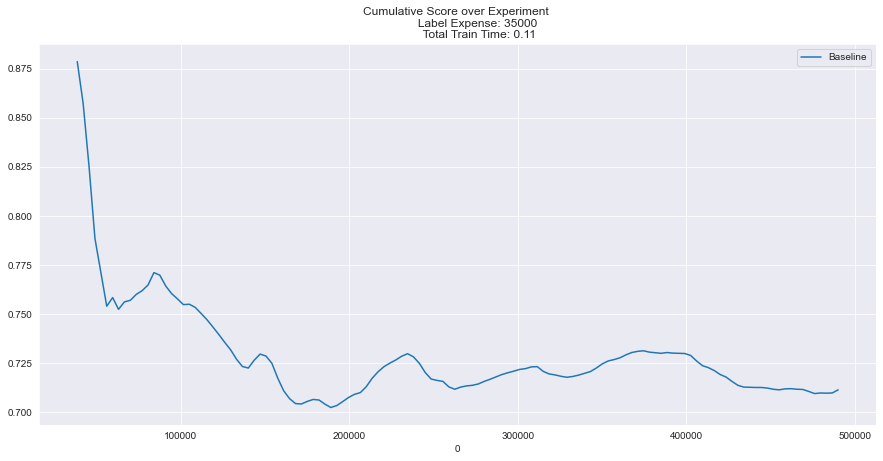

In [13]:
plot_experiment_error(baseline)

### Uncertainty KS Debug

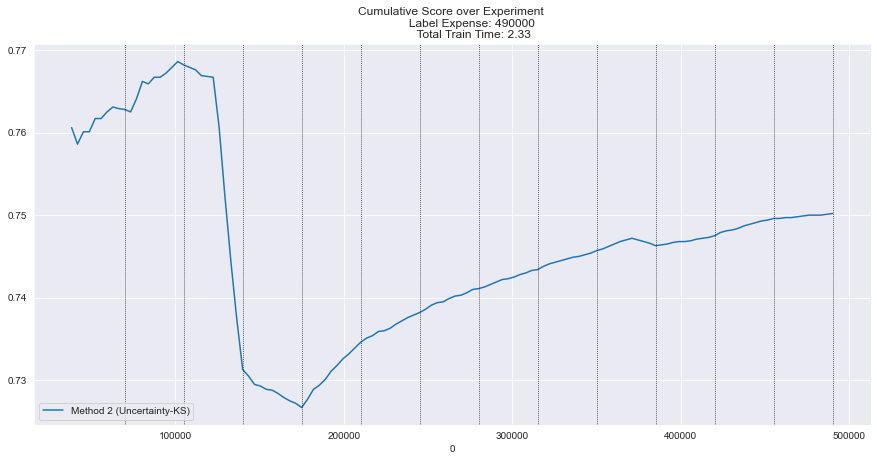

In [20]:
plot_experiment_error(uncertainty_ks)

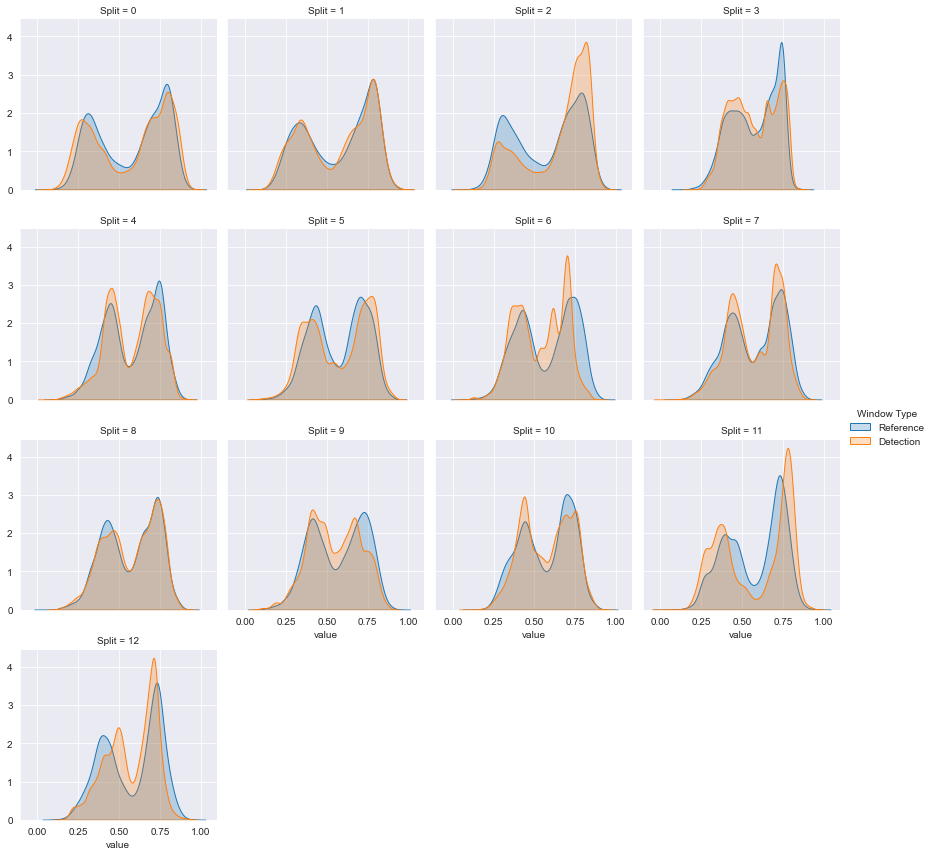

In [21]:
plot_response_distributions_bysplit(uncertainty_ks)

### Margin Uncertainty Debug

Same Distribution: False
Expected Distribution: [0.9336, 0.0664]
Observed Distribution: [0.9536857142857142, 0.04631428571428572]
Percent change in margin: 0.3025
Number in Margin: Before 2324 | After 1621 | Difference 703
Chi-Square Results: Power_divergenceResult(statistic=227.77900068876315, pvalue=1.818509239916743e-51)

Same Distribution: False
Expected Distribution: [0.9271142857142857, 0.07288571428571429]
Observed Distribution: [0.9425714285714286, 0.057428571428571426]
Percent change in margin: 0.2121
Number in Margin: Before 2551 | After 2010 | Difference 541
Chi-Square Results: Power_divergenceResult(statistic=123.75159311299453, pvalue=9.547869430704045e-29)

Same Distribution: False
Expected Distribution: [0.9250285714285714, 0.07497142857142858]
Observed Distribution: [0.952, 0.048]
Percent change in margin: 0.3598
Number in Margin: Before 2624 | After 1680 | Difference 944
Chi-Square Results: Power_divergenceResult(statistic=367.13434221073123, pvalue=7.873051724600469e-

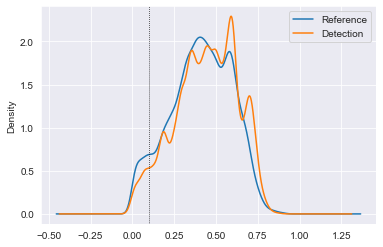

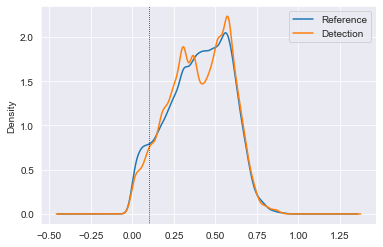

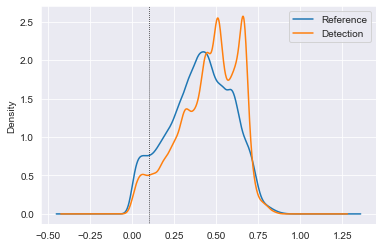

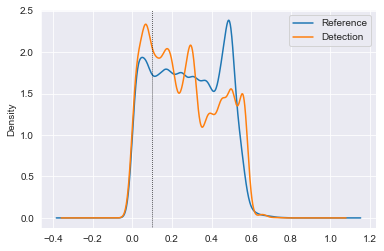

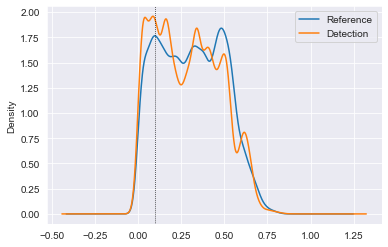

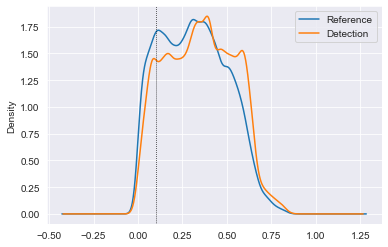

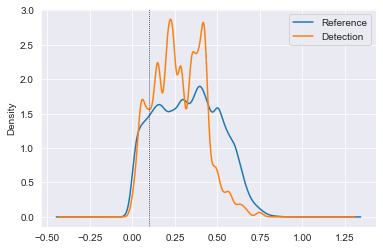

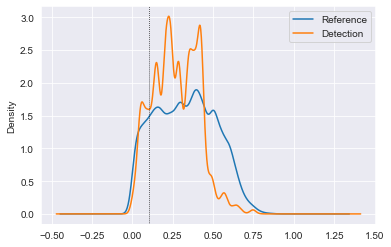

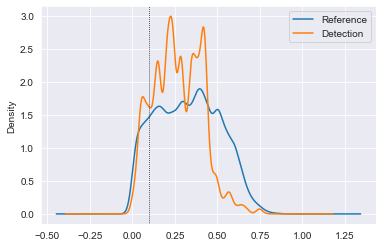

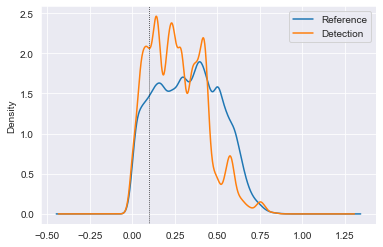

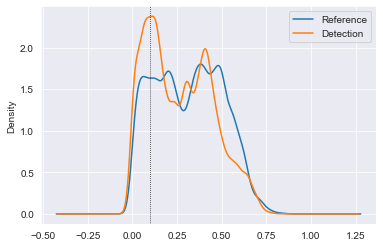

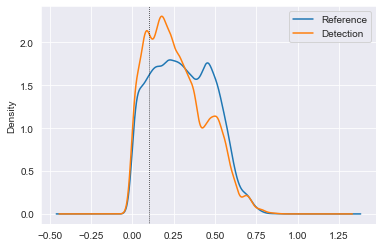

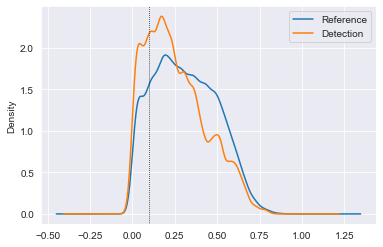

In [22]:
plot_margin_distributions_bysplit(uncertainty_x2)